In [5]:
# =====================================================
# ASL Alphabet Detection using CNN (Kaggle GPU Version)
# =====================================================

import os
import cv2
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# =====================================================
# 1. Paths
# =====================================================
train_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir  = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

# =====================================================
# 2. Fast Parallel Data Loader
# =====================================================
def process_image(img_path, label):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None, None
        img = cv2.resize(img, (64, 64))
        img = img.astype('float32') / 255.0
        return img, label
    except:
        return None, None

def load_train_data_parallel(data_dir, n_jobs=-1):
    data, labels = [], []
    classes = sorted(os.listdir(data_dir))
    for category in tqdm(classes, desc="Loading Training Data"):
        folder_path = os.path.join(data_dir, category)
        if not os.path.isdir(folder_path):
            continue
        img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
        results = Parallel(n_jobs=n_jobs, backend="threading")(
            delayed(process_image)(p, category) for p in img_paths
        )
        for img, label in results:
            if img is not None:
                data.append(img)
                labels.append(label)
    return np.array(data), np.array(labels)

def load_test_data_parallel(data_dir, n_jobs=-1):
    img_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".jpg")]
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(process_image)(p, os.path.basename(p).split('_')[0].upper()) for p in img_paths
    )
    data, labels = zip(*[(img, label) for img, label in results if img is not None])
    return np.array(data), np.array(labels)

# =====================================================
# 3. Load Data
# =====================================================
X_train, y_train = load_train_data_parallel(train_dir)
X_test, y_test   = load_test_data_parallel(test_dir)

print("\n Data Loaded Successfully!")
print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

# =====================================================
# 4. Encode Labels
# =====================================================
y_train = np.char.upper(y_train)
y_test  = np.char.upper(y_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)
print("\nDetected Classes:", num_classes, " -> ", list(le.classes_))



Loading Training Data: 100%|██████████| 29/29 [03:01<00:00,  6.27s/it]



 Data Loaded Successfully!
Train Data Shape: (87000, 64, 64)
Test Data Shape: (28, 64, 64)

Detected Classes: 29  ->  ['A', 'B', 'C', 'D', 'DEL', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'NOTHING', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [7]:
#=====================================================
# 5. Prepare Data for CNN
# =====================================================
X_train = X_train.reshape(-1, 64, 64, 1)
X_test  = X_test.reshape(-1, 64, 64, 1)

y_train_cat = to_categorical(y_train_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)

# =====================================================
# 6. Define CNN Model
# =====================================================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# =====================================================
# 7. Compile Model
# =====================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =====================================================
# 8. Train Model
# =====================================================
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    verbose=1
)

# =====================================================
# 9. Evaluate Model
# =====================================================
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4101 - loss: 2.0658 - val_accuracy: 0.0960 - val_loss: 14.4494
Epoch 2/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8954 - loss: 0.3005 - val_accuracy: 0.1529 - val_loss: 16.7026
Epoch 3/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9560 - loss: 0.1246 - val_accuracy: 0.2282 - val_loss: 17.8199
Epoch 4/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9738 - loss: 0.0786 - val_accuracy: 0.2080 - val_loss: 14.9468
Epoch 5/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9767 - loss: 0.0722 - val_accuracy: 0.2959 - val_loss: 20.8526
Epoch 6/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9822 - loss: 0.0576 - val_accuracy: 0.2923 - val_loss: 17.5543
Epoch 7/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9858 - loss: 0.0460 - val_accuracy: 0.2767 - val_loss: 25.9657
Epoch 8/15
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9866 - loss: 0.

In [17]:
# =====================================================
# 10. Predict ASL Sign from a Given Input Image
# =====================================================
import cv2
import numpy as np

def predict_asl_image(image_path):
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(" Error: Image not found.")
        return
    img = cv2.resize(img, (64, 64))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = le.inverse_transform([predicted_class])[0]  # <-- fixed here

    print(f" Predicted Sign: {predicted_label.upper()}")

# Example usage
test_image_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/space_test.jpg"
predict_asl_image(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
 Predicted Sign: P


**SECOND METHOD**

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (64, 64)
batch_size = 64

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("\nClass indices used in training:")
print(train_data.class_indices)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.

Class indices used in training:
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(64,64,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,739,613 (10.45 MB)

 Trainable params: 2,738,717 (10.45 MB)

 Non-trainable params: 896 (3.50 KB)

In [32]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)

# ===
val_loss, val_acc = model.evaluate(val_data, verbose=1)
print(f"\n Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 242s 223ms/step - accuracy: 0.9945 - loss: 0.0250 - val_accuracy: 0.7962 - val_loss: 2.1888
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 231s 212ms/step - accuracy: 0.9948 - loss: 0.0284 - val_accuracy: 0.8371 - val_loss: 1.8029
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 229s 210ms/step - accuracy: 0.9943 - loss: 0.0305 - val_accuracy: 0.8376 - val_loss: 1.1059
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 240s 221ms/step - accuracy: 0.9948 - loss: 0.0281 - val_accuracy: 0.6662 - val_loss: 8.1273
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 334s 307ms/step - accuracy: 0.9965 - loss: 0.0155 - val_accuracy: 0.6418 - val_loss: 4.6310
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 271s 249ms/step - accuracy: 0.9952 - loss: 0.0282 - val_accuracy: 0.8422 - val_loss: 1.7168
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 222s 204ms/step - accuracy: 0.9966 - loss: 0.0182 - val_accuracy: 0.7639 - val_loss: 4.1280
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 234s 215ms/step - ac

**THIRD METHOD**

In [4]:
import os

train_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir  = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

# List the first few folders in train
print("=== TRAIN FOLDERS ===")
train_classes = sorted(os.listdir(train_dir))
print(train_classes[:])
print(f"\nTotal train folders: {len(train_classes)}")

# List the test image files
print("\n=== TEST IMAGES ===")
test_files = sorted(os.listdir(test_dir))
print(test_files[:])
print(f"\nTotal test images: {len(test_files)}")


=== TRAIN FOLDERS ===
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Total train folders: 29

=== TEST IMAGES ===
['A_test.jpg', 'B_test.jpg', 'C_test.jpg', 'D_test.jpg', 'E_test.jpg', 'F_test.jpg', 'G_test.jpg', 'H_test.jpg', 'I_test.jpg', 'J_test.jpg', 'K_test.jpg', 'L_test.jpg', 'M_test.jpg', 'N_test.jpg', 'O_test.jpg', 'P_test.jpg', 'Q_test.jpg', 'R_test.jpg', 'S_test.jpg', 'T_test.jpg', 'U_test.jpg', 'V_test.jpg', 'W_test.jpg', 'X_test.jpg', 'Y_test.jpg', 'Z_test.jpg', 'nothing_test.jpg', 'space_test.jpg']

Total test images: 28


In [5]:
# =====================================================
# ASL Alphabet Detection using CNN (Kaggle GPU Version)
# =====================================================

import os
import cv2
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =====================================================
# 1. Paths
# =====================================================
train_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir  = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

# =====================================================
# 2. Parallel Data Loader (RGB Version)
# =====================================================
def process_image(img_path, label):
    try:
        img = cv2.imread(img_path)  # RGB
        if img is None:
            return None, None
        img = cv2.resize(img, (64, 64))
        img = img.astype('float32') / 255.0
        return img, label
    except:
        return None, None

def load_train_data_parallel(data_dir, n_jobs=-1):
    data, labels = [], []
    classes = sorted(os.listdir(data_dir))
    for category in tqdm(classes, desc="Loading Training Data"):
        if category == "del":  # optional: remove 'del' since not in test
            continue
        folder_path = os.path.join(data_dir, category)
        if not os.path.isdir(folder_path):
            continue
        img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
        results = Parallel(n_jobs=n_jobs, backend="threading")(
            delayed(process_image)(p, category.lower()) for p in img_paths
        )
        for img, label in results:
            if img is not None:
                data.append(img)
                labels.append(label)
    return np.array(data), np.array(labels)

def load_test_data_parallel(data_dir, n_jobs=-1):
    img_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".jpg")]
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(process_image)(
            p, os.path.basename(p).split('_test')[0].lower()
        ) for p in img_paths
    )
    data, labels = zip(*[(img, label) for img, label in results if img is not None])
    return np.array(data), np.array(labels)

# =====================================================
# 3. Load Data
# =====================================================
X_train, y_train = load_train_data_parallel(train_dir)
X_test, y_test   = load_test_data_parallel(test_dir)

print("\n Data Loaded Successfully!")
print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

# =====================================================
# 4. Encode Labels
# =====================================================
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)
print("\nDetected Classes:", num_classes, "->", list(le.classes_))


Loading Training Data: 100%|██████████| 29/29 [01:50<00:00,  3.82s/it]



 Data Loaded Successfully!
Train Data Shape: (84000, 64, 64, 3)
Test Data Shape: (28, 64, 64, 3)

Detected Classes: 28 -> ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# =====================================================
# 5. Prepare Data
# =====================================================
y_train_cat = to_categorical(y_train_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)

# =====================================================
# 6. Data Augmentation
# =====================================================
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# =====================================================
# 7. CNN Model (Improved)
# =====================================================
from tensorflow.keras import Input

model = Sequential([
    Input(shape=(64,64,3)),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# =====================================================
# 8. Compile Model
# =====================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =====================================================
# 9. Split Data for Validation and Train Model
# =====================================================
from sklearn.model_selection import train_test_split

# Manual split (since validation_split doesn’t work with generators)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_cat,
    test_size=0.1,
    random_state=42,
    stratify=y_train_cat
)

# Train with augmented data
history = model.fit(
    datagen.flow(X_train_split, y_train_split, batch_size=128),
    validation_data=(X_val_split, y_val_split),
    epochs=10,
    verbose=1
)

# =====================================================
# 10. Evaluate Model
# =====================================================
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 101s 153ms/step - accuracy: 0.1946 - loss: 3.0858 - val_accuracy: 0.4495 - val_loss: 2.2486
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.5851 - loss: 1.2569 - val_accuracy: 0.8267 - val_loss: 0.5149
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.7608 - loss: 0.6938 - val_accuracy: 0.8957 - val_loss: 0.3060
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.8445 - loss: 0.4517 - val_accuracy: 0.9144 - val_loss: 0.2431
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.8847 - loss: 0.3215 - val_accuracy: 0.9171 - val_loss: 0.2700
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 81s 137ms/step - accuracy: 0.9138 - loss: 0.2491 - val_accuracy: 0.9846 - val_loss: 0.0532
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.9295 - loss: 0.2050 - val_accuracy: 0.9492 - val_loss: 0.1506
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 81s 138ms/step - accuracy: 0.9384 - loss: 

In [7]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (84000, 64, 64, 3)
Test shape: (28, 64, 64, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


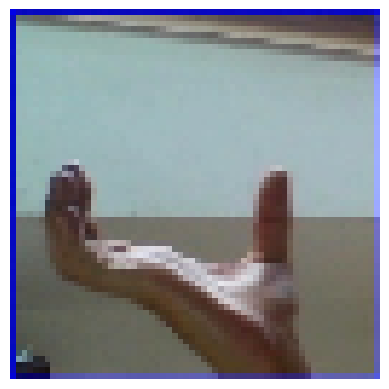

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


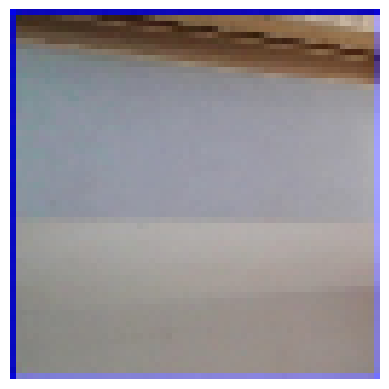

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


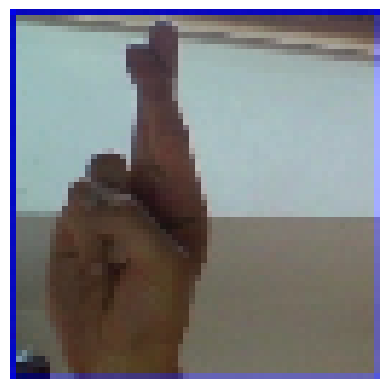

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Ensure label_encoder is available (recreate if not)
from sklearn.preprocessing import LabelEncoder

train_classes = sorted(['A','B','C','D','E','F','G','H','I','J','K','L','M',
                        'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                        'del','nothing','space'])
label_encoder = LabelEncoder()
label_encoder.fit(train_classes)

# Prediction function
def predict_asl_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Test example
predict_asl_image("/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/space_test.jpg")
predict_asl_image("/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg")
predict_asl_image("/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/R_test.jpg")

